In [ ]:
from google.colab import drive
import glob
import json
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_directory='/content/gdrive/MyDrive/CV Final'
dataset_directory=data_directory+'/ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21'
target_list=[ 'area', 'heatmap','horizontal_interval', 'manhattan', 'map', 'pie', 'scatter-line','surface', 'venn', 'vertical_box','vertical_interval', 'vertical_bar', 'scatter','line']
annotations_directory=dataset_directory+'/annotations_JSON'
images_directory=dataset_directory+'/images'

In [ ]:
print(len(glob.glob(images_directory+'/vertical_bar/*')))

3818


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchsummary import summary
from torchvision.models import resnet
import torchvision
import os
import glob
import json

from scipy import ndimage,io
from skimage import io, transform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
def normalize(img):
  mx = np.max(img)
  mn = np.min(img)
  return (img-mn)/(mx-mn)

In [64]:
class AdobeDataset(Dataset):
  def __init__(self,root_dir,chart_type="line"):
    self.chart_type = chart_dict[chart_type]
    self.image_dir = os.path.join(root_dir,"ICPR","Charts",chart_type)
    self.annot_dir = os.path.join(root_dir,"JSONs",chart_type)
    image_filenames = os.listdir(self.annot_dir)#glob.glob("{}/{}".format(self.annot_dir,"*"))
    self.image_filenames = [fn[:-5] for fn in image_filenames]

  def __len__(self):
    return len(self.image_filenames)

  def __getitem__(self,idx):
    img_filename = self.image_filenames[idx]
    img = cv2.imread(os.path.join(self.image_dir,img_filename+".png"))
    with open(os.path.join(self.annot_dir,img_filename+".json")) as annot_file:
      annots = json.loads("".join(annot_file.readlines()))["task6"]
    
    if self.chart_type == "bar":
      heatmaps = np.zeros((*img.shape[:2],3))
      for bar in annots["output"]["visual elements"]["bars"]:
        h,w,x0,y0 = bar.values()
        heatmaps[y0,x0,0] = 1
        heatmaps[y0+h,x0+w,1] = 1
        heatmaps[y0+h//2,x0+w//2,2] = 1
      heatmaps = normalize(ndimage.filters.gaussian_filter(heatmaps,[2,2,0]))
    elif self.chart_type == "box":
      heatmaps = np.zeros((*img.shape[:2],3))
      for box in annots["output"]["visual elements"]["boxplots"]:
        for i,part in enumerate(box.values()):
          bbox =part["_bb"]
          #print('bbox ',bbox.values())
          h,w,x0,y0 = bbox.values()
          heatmaps[y0,x0,0] = 1
          heatmaps[y0+h,x0+w,1] = 1
          heatmaps[y0+h//2,x0+w//2,2] = 1
      heatmaps = normalize(ndimage.filters.gaussian_filter(heatmaps,[2,2,0]))
    elif self.chart_type == "line":
      heatmaps = np.zeros((*img.shape[:2],len(annots["output"]["visual elements"]["lines"])))
      for i,line in enumerate(annots["output"]["visual elements"]["lines"]):
        for point in line:
          x,y = point.values()
          heatmaps[y,x,i] = 1
      heatmaps = normalize(ndimage.filters.gaussian_filter(heatmaps,[2,2,0]))
    elif self.chart_type == "scatter":
      heatmaps = np.zeros((*img.shape[:2],1))
      for point in annots["output"]["visual elements"]["scatter points"]:
        x,y = point.values()
        heatmaps[y,x,0] = 1
      heatmaps = normalize(ndimage.filters.gaussian_filter(heatmaps,[2,2,0]))
    print(img.shape)
    return img,annots,heatmaps

In [ ]:
chart_dict = {
  "hbox":"box",
  "hGroup":"bar",
  "hStack":"bar",
  "vbox":"box",
  "vGroup":"bar",
  "vStack":"bar",
  "line":"line",
  "scatter":"scatter"
}

In [ ]:
def cleanData(root_dir):
  for chart_type in ["horizontal_bar","vertical_bar","vertical_box","line","scatter"]:
    image_dir = os.path.join(root_dir,"images",chart_type)
    annot_dir = os.path.join(root_dir,"annotations_JSON",chart_type)
    image_filenames = os.listdir(annot_dir)
    print(len(image_filenames))
    continue
    good_files = []
    for i,filename in enumerate(image_filenames):
      if filename[-5:] != ".json" and filename[-5:] != ".JSON":
        good_files.append(False)
        continue
      with open(os.path.join(annot_dir,filename)) as annot_file:
        lines = annot_file.readlines()
        if len(lines) == 0:
          good_files.append(False)
          continue
        try:
          good_files.append(json.loads("".join(lines))["task6"]!=None)
        except KeyError:
          good_files.append(False)
    for i,filename in enumerate(image_filenames):
      print(os.path.join(annot_dir,filename))
      if not good_files[i]:
        with open(os.path.join(annot_dir,filename)) as annot_file:
          print(annot_file.readlines())
        os.remove(os.path.join(annot_dir,filename))
cleanData("/content/gdrive/MyDrive/CV Final/ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21/")

429
3818
316
7401
875


In [ ]:
#https://github.com/JavisPeng/CenterNet-pytorch-detection-simple-tutorial/blob/master/models.py
import torch.nn as nn
import torch
import math

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class CNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # /2
        self.layer1 = self._make_layer(block, 64, layers[0])  # /4
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # /8
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # /16
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # /32

        self.layer5 = self._make_deconv_layer(512, 256)  # /16
        self.layer6 = self._make_deconv_layer(256, 128)  # /8
        self.layer7 = self._make_deconv_layer(128, 64)  # /4

        self.hm = self._make_header_layer(64, num_classes)  # heatmap
        self.wh = self._make_header_layer(64, 2)  # width and height
        self.reg = self._make_header_layer(64, 2)  # regress offset

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    # add for three headers
    def _make_header_layer(self, in_ch, out_ch):
        header = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, out_ch, 1, 1)
        )
        return header

    # add for upsample
    def _make_deconv_layer(self, in_ch, out_ch):
        deconv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        return deconv

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        return self.hm(x), self.wh(x), self.reg(x)


backbones = {18: (BasicBlock, [2, 2, 2, 2]),
             34: (BasicBlock, [3, 4, 6, 3]),
             50: (Bottleneck, [3, 4, 6, 3]),
             101: (Bottleneck, [3, 4, 23, 3]),
             152: (Bottleneck, [3, 8, 36, 3])}


def cnet(nb_res=18, **kwargs) -> nn.Module:
    block, layers = backbones[nb_res]
    model = CNet(BasicBlock, layers, **kwargs)
    return model



In [56]:
from torchsummary import summary

x = torch.randn(1, 3, 1024, 1024)
model = cnet()

hm, wh, reg = model(x)

summary(model,(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

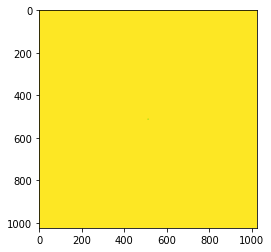

In [59]:
x = torch.ones(1, 3, 1024, 1024)
model = cnet()
t=[512]
for i in t:
  x[0,0,i,i]=0
  x[0,1,i,i]=0
  x[0,2,i,i]=0
  x[0,0,i,i+1]=0
  x[0,1,i,i+1]=0
  x[0,2,i,i+1]=0
  x[0,0,i,i-1]=0
  x[0,1,i,i-1]=0
  x[0,2,i,i-2]=0
  x[0,0,i,i+2]=0
  x[0,1,i,i+2]=0
  x[0,2,i,i+2]=0
  x[0,0,i,i-2]=0
  x[0,1,i,i-2]=0
  x[0,2,i,i-2]=0
plt.figure()
plt.imshow(x[0][1])
hm, wh, reg = model(x)


torch.Size([1000, 256, 256])
(256, 256)


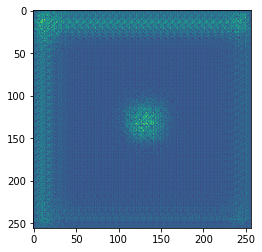

In [60]:
#print(hm.shape)

print(hm[0].shape)
op=(np.array(hm[0][0].detach()))
print(op.shape)

plt.figure()
plt.imshow(op)

torch.Size([1, 1000, 256, 256])
(1000, 256, 256)


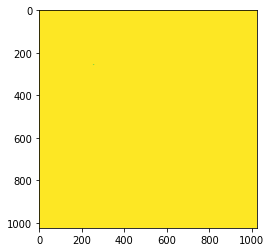

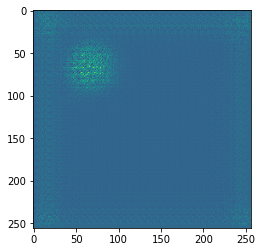

In [63]:
# https://github.com/ucbdrive/dla/blob/master/dla.py

import math
from os.path import join

import torch
from torch import nn
import torch.utils.model_zoo as model_zoo
import matplotlib.pyplot as plt
import numpy as np
# import dataset

BatchNorm = nn.BatchNorm2d

WEB_ROOT = 'http://dl.yf.io/dla/models'


def get_model_url(data, name):
    return join(WEB_ROOT, data.name,
                '{}-{}.pth'.format(name, data.model_hash[name]))


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, dilation=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3,
                               stride=stride, padding=dilation,
                               bias=False, dilation=dilation)
        self.bn1 = BatchNorm(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=dilation,
                               bias=False, dilation=dilation)
        self.bn2 = BatchNorm(planes)
        self.stride = stride

    def forward(self, x, residual=None):
        if residual is None:
            residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, dilation=1):
        super(Bottleneck, self).__init__()
        expansion = Bottleneck.expansion
        bottle_planes = planes // expansion
        self.conv1 = nn.Conv2d(inplanes, bottle_planes,
                               kernel_size=1, bias=False)
        self.bn1 = BatchNorm(bottle_planes)
        self.conv2 = nn.Conv2d(bottle_planes, bottle_planes, kernel_size=3,
                               stride=stride, padding=dilation,
                               bias=False, dilation=dilation)
        self.bn2 = BatchNorm(bottle_planes)
        self.conv3 = nn.Conv2d(bottle_planes, planes,
                               kernel_size=1, bias=False)
        self.bn3 = BatchNorm(planes)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

    def forward(self, x, residual=None):
        if residual is None:
            residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += residual
        out = self.relu(out)

        return out


class BottleneckX(nn.Module):
    expansion = 2
    cardinality = 32

    def __init__(self, inplanes, planes, stride=1, dilation=1):
        super(BottleneckX, self).__init__()
        cardinality = BottleneckX.cardinality
        # dim = int(math.floor(planes * (BottleneckV5.expansion / 64.0)))
        # bottle_planes = dim * cardinality
        bottle_planes = planes * cardinality // 32
        self.conv1 = nn.Conv2d(inplanes, bottle_planes,
                               kernel_size=1, bias=False)
        self.bn1 = BatchNorm(bottle_planes)
        self.conv2 = nn.Conv2d(bottle_planes, bottle_planes, kernel_size=3,
                               stride=stride, padding=dilation, bias=False,
                               dilation=dilation, groups=cardinality)
        self.bn2 = BatchNorm(bottle_planes)
        self.conv3 = nn.Conv2d(bottle_planes, planes,
                               kernel_size=1, bias=False)
        self.bn3 = BatchNorm(planes)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

    def forward(self, x, residual=None):
        if residual is None:
            residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += residual
        out = self.relu(out)

        return out


class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, residual):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, bias=False, padding=(kernel_size - 1) // 2)
        self.bn = BatchNorm(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.residual = residual

    def forward(self, *x):
        children = x
        x = self.conv(torch.cat(x, 1))
        x = self.bn(x)
        if self.residual:
            x += children[0]
        x = self.relu(x)

        return x


class Tree(nn.Module):
    def __init__(self, levels, block, in_channels, out_channels, stride=1,
                 level_root=False, root_dim=0, root_kernel_size=1,
                 dilation=1, root_residual=False):
        super(Tree, self).__init__()
        self.dil=dilation
        if root_dim == 0:
            root_dim = 2 * out_channels
        if level_root:
            root_dim += in_channels
        if levels == 1:
            self.tree1 = block(in_channels, out_channels, stride,
                               dilation=self.dil)
            self.tree2 = block(out_channels, out_channels, 1,
                               dilation=self.dil)
        else:
            self.tree1 = Tree(levels - 1, block, in_channels, out_channels,
                              stride, root_dim=0,
                              root_kernel_size=root_kernel_size,
                              dilation=self.dil, root_residual=root_residual)
            self.tree2 = Tree(levels - 1, block, out_channels, out_channels,
                              root_dim=root_dim + out_channels,
                              root_kernel_size=root_kernel_size,
                              dilation=self.dil, root_residual=root_residual)
        if levels == 1:
            self.root = Root(root_dim, out_channels, root_kernel_size,
                             root_residual)
        self.level_root = level_root
        self.root_dim = root_dim
        self.downsample = None
        self.project = None
        self.levels = levels
        if stride > 1:
            self.downsample = nn.MaxPool2d(stride, stride=stride)
        if in_channels != out_channels:
            self.project = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=1, bias=False),
                BatchNorm(out_channels)
            )

    def forward(self, x, residual=None, children=None):
        children = [] if children is None else children
        bottom = self.downsample(x) if self.downsample else x
        residual = self.project(bottom) if self.project else bottom
        if self.level_root:
            children.append(bottom)
        x1 = self.tree1(x, residual)
        if self.levels == 1:
            x2 = self.tree2(x1)
            x = self.root(x2, x1, *children)
        else:
            children.append(x1)
            x = self.tree2(x1, children=children)
        return x


class DLA(nn.Module):
    def __init__(self, levels, channels, num_classes=1000,
                 block=BasicBlock, residual_root=False, return_levels=False,
                 pool_size=7, linear_root=False):
        super(DLA, self).__init__()
        self.channels = channels
        self.return_levels = return_levels
        self.num_classes = num_classes
        self.base_layer = nn.Sequential(
            nn.Conv2d(3, channels[0], kernel_size=7, stride=1,
                      padding=3, bias=False),
            BatchNorm(channels[0]),
            nn.ReLU(inplace=True))
        self.level0 = self._make_conv_level(
            channels[0], channels[0], levels[0])
        self.level1 = self._make_conv_level(
            channels[0], channels[1], levels[1], stride=2)
        self.level2 = Tree(levels[2], block, channels[1], channels[2], 2,
                           level_root=False,
                           root_residual=residual_root)
        self.level3 = Tree(levels[3], block, channels[2], channels[3], 2,
                           level_root=True, root_residual=residual_root)
        self.level4 = Tree(levels[4], block, channels[3], channels[4], 2,
                           level_root=True, root_residual=residual_root)
        self.level5 = Tree(levels[5], block, channels[4], channels[5], 2,
                           level_root=True, root_residual=residual_root)

        # self.avgpool = nn.AvgPool2d(pool_size)
        # self.fc = nn.Conv2d(channels[-1], num_classes, kernel_size=1,
        #                     stride=1, padding=0, bias=True)


        self.layer5 = self._make_deconv_layer(512, 256)  # /16
        self.layer6 = self._make_deconv_layer(256, 128)  # /8
        self.layer7 = self._make_deconv_layer(128, 64)  # /4
        self.hm = self._make_header_layer(64, num_classes)  # heatmap
        self.wh = self._make_header_layer(64, 2)  # width and height
        self.reg = self._make_header_layer(64, 2)  # regress offset
        # print(self)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, BatchNorm):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    # add for upsample
    def _make_deconv_layer(self, in_ch, out_ch):
        deconv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        return deconv

    # add for three headers
    def _make_header_layer(self, in_ch, out_ch):
        header = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, out_ch, 1, 1)
        )
        return header

    def _make_level(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes:
            downsample = nn.Sequential(
                nn.MaxPool2d(stride, stride=stride),
                nn.Conv2d(inplanes, planes,
                          kernel_size=1, stride=1, bias=False),
                BatchNorm(planes),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample=downsample))
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_conv_level(self, inplanes, planes, convs, stride=1, dilation=1):
        modules = []
        for i in range(convs):
            modules.extend([
                nn.Conv2d(inplanes, planes, kernel_size=3,
                          stride=stride if i == 0 else 1,
                          padding=dilation, bias=False, dilation=dilation),
                BatchNorm(planes),
                nn.ReLU(inplace=True)])
            inplanes = planes
        return nn.Sequential(*modules)

    def forward(self, x):
        y = []
        x = self.base_layer(x)
        for i in range(6):
            x = getattr(self, 'level{}'.format(i))(x)
            y.append(x)
        if self.return_levels:
            print('Y',y.shape)
            return y
        else:
            # x = self.avgpool(x)
            # x = self.fc(x)
            # x = x.view(x.size(0), -1)
            # print('X',x.shape)
            # return x
            x = self.layer5(x)
            x = self.layer6(x)
            x = self.layer7(x)
            return self.hm(x), self.wh(x), self.reg(x)

    def load_pretrained_model(self, data_name, name):
        assert data_name in dataset.__dict__, \
            'No pretrained model for {}'.format(data_name)
        data = dataset.__dict__[data_name]
        fc = self.fc
        if self.num_classes != data.classes:
            self.fc = nn.Conv2d(
                self.channels[-1], data.classes,
                kernel_size=1, stride=1, padding=0, bias=True)
        try:
            model_url = get_model_url(data, name)
        except KeyError:
            raise ValueError(
                '{} trained on {} does not exist.'.format(data.name, name))
        self.load_state_dict(model_zoo.load_url(model_url))
        self.fc = fc


def dla34(pretrained=None, **kwargs):  # DLA-34
    model = DLA([1, 1, 1, 2, 2, 1],
                [16, 32, 64, 128, 256, 512],
                block=BasicBlock, **kwargs)
    if pretrained is not None:
        model.load_pretrained_model(pretrained, 'dla34')
    return model

mod=dla34()
# print(mod)
x=torch.ones((1,3,1024,1024))
t=[256]
for i in t:
  x[0,0,i,i]=0
  x[0,1,i,i]=0
  x[0,2,i,i]=0
  x[0,0,i,i+1]=0
  x[0,1,i,i+1]=0
  x[0,2,i,i+1]=0
  x[0,0,i,i-1]=0
  x[0,1,i,i-1]=0
  x[0,2,i,i-2]=0
  x[0,0,i,i+2]=0
  x[0,1,i,i+2]=0
  x[0,2,i,i+2]=0
  x[0,0,i,i-2]=0
  x[0,1,i,i-2]=0
  x[0,2,i,i-2]=0
plt.figure()
plt.imshow(x[0][1])
x=mod(x)
print(x[0].shape)
xx=(np.array(x[0][0].detach()))
print(xx.shape)

plt.figure()
plt.imshow(xx[1])

In [ ]:
 class FocalLoss(nn.Module):

    def __init__(self, alpha=2, beta=4):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, output, target, sigmoid=True):
        if sigmoid:  # clamp is important
            output = torch.clamp(output.sigmoid(), min=1e-4, max=1 - 1e-4)

        pos_index = target.eq(1).float()
        neg_index = target.lt(1).float()

        pos_loss = torch.pow(1 - output, self.alpha) * torch.log(output) * pos_index
        neg_loss = torch.pow(1 - target, self.beta) * torch.pow(output, self.alpha) * torch.log(1 - output) * neg_index

        pos_loss = pos_loss.sum()
        neg_loss = neg_loss.sum()
        pos_num = pos_index.sum()
        loss = 0
        loss = loss - (pos_loss + neg_loss) / pos_num if pos_num > 0 else loss - neg_loss

        return loss


class RegL1Loss(nn.Module):

    def __init__(self):
        super(RegL1Loss, self).__init__()
        # 只统计包含目标的元素
        self.l1_loss = nn.L1Loss(reduction='sum')
        self.eps = 1e-4

    def forward(self, output: torch.Tensor, target: torch.Tensor, mask: torch.Tensor, index: torch.Tensor):
        '''
        l1_loss from wh_loss or off_loss
        :param output: the output of model (batch,2,128,128)
        :param target: (batch,max_objs,2)   max_objs=128
        :param mask: (batch,max_objs)
        :param index: (batch,max_objs)
        :return:
        '''
        # index为1维索引,把output的特征图也转成1维
        batch = output.size(0)
        output = output.view(batch, 2, -1).transpose(1, 2).contiguous()  # (batch,128*128,2)
        # torch.gather函数需要index的维度和output保持一致(提取那一维除外)
        index = index.unsqueeze(2).expand(batch, -1, 2)  # (batch,max_objs,2)
        # get the target number
        pos_num = mask.sum()
        # 提取target对应feature值
        output = torch.gather(output, 1, index)  # (batch,max_objs,2)
        # 使用mask对无目标的output进行mask,先扩展维度
        mask = mask.unsqueeze(2).expand_as(output).float()  # (batch,max_objs,2)

        loss = self.l1_loss(output * mask, target * mask)
        loss = loss / (pos_num + self.eps)
        return loss

In [65]:
root_dir = "/content/gdrive/MyDrive/CV Final/ICPR_ChartCompetition2020_AdobeData"
chart_type='hGroup'
trainset = AdobeDataset(root_dir,chart_type)

In [ ]:
next(iter(trainset))

In [68]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=45, shuffle=False, num_workers=2)

In [ ]:
##Train CenterNet

cerition_hm = FocalLoss()
cerition_wh = RegL1Loss()
cerition_reg = RegL1Loss()
optimizer = optim.Adam(model.parameters(),lr-0.01)
loss_meter, it = 0, 0

for item in bar:
    item = [x.to(device) for x in item]
    img, hm, wh, reg, ind, reg_mask = item
    optimizer.zero_grad()
    out_hm, out_wh, out_reg = model(img)
    
    loss = hm_loss + 0.1 * wh_loss + reg_loss
    loss.backward()
    optimizer.step()
    loss_meter += loss.item()
    bar.set_postfix(hm_loss=hm_loss.item(), wh_loss=wh_loss.item(), reg_loss=reg_loss.item(), loss=loss.item())
    it += 1

In [ ]:
for i in range(1):
    for j,data in enumerate(trainloader):
      #print(j)
      #print(data[0].shape)
      #print(data[1].shape)
      # print(len(data))
      
      #print(j)
      model.train()
      #if torch.cuda.is_available():
      input_img = data[0].to(device)
      input_anno = data[1].to(device)
      input_hm = data[2].to(device)
      model.to(device)

      # print(target.shape)
      output_hm, output_hw, output_reg  = model(input_img)
      # print(output.shape)
      # loss = criterion(output,torch.reshape(target.long(),(bs,224,224)))
      hm_loss = cerition_hm(output_hm, input_hm)
      wh_loss = cerition_wh(input_anno, output_hw)
      reg_loss = cerition_reg(out_reg, reg, reg_mask, ind)
      # loss = my_loss(output, target)

      print(loss)

      loss.backward()
      # optimizer.step()
      optimizer.zero_grad()
      loss_meter += loss.item()
